# Лабораторная работа по Relevance Vector Regression
В рамках этой лабораторной работы необходимо:
- Имплементировать Relevance Vector Regression
- Применить на синетическом датасете (восстановление полинома), сравнить с Lasso из sklearn и гребневой регрессией
- Применить на данных sinc с RBF признаками, визуализировать "релевантные вектора", сравнить с Support Vector Regression и Lasso
- Сделать выводы

In [1]:
import numpy as np
from scipy.linalg import inv
from matplotlib import pyplot as plt
from IPython.display import clear_output

%matplotlib inline
np.random.seed(123)

def l2_error(X, t, w):
    return np.sum((X.dot(w.ravel()) - t) ** 2)

## Имплементация Relevance Vector Regression

Здесь необходимо реализовать три функции:

1. `get_w_sigma(X, t, alpha, beta)`, которая принимает датасет (X, t) и гиперпараметры RVR (alpha, beta) и возвращает параметры апостериорного распределения mu, sigma
2. `update_alpha_beta(X, t, alpha, beta)`, которая принимает датасет (X, t) и гиперпараметры RVR (alpha, beta) и делает один шаг итерационной процедуры для обновления гиперпараметров (было на лекции)
3. `fit_rvr(X, t, max_iters)`, которая принимает датасет (X, t) и максимальное количество итераций и возвращает обученные гиперпараметры и параметры апостериорного распределения на веса модели

На что стоит обратить внимание:

1. Результаты дорогостоящих операций типа перемножения одних и тех же матриц можно кешировать и переиспользовать
2. $\alpha$-ы для нерелевантных объектов должны принять значение `np.inf`, а соответствующие веса и их дисперсии должны иметь значение 0
3. Бесконечности и нули из предыдущего пункта должны обрабатываться корректно, без NaN-ов и warning-ов
4. Матрицу с бесконечными элементами на диагонали можно обращать более эффективно (достаточно обратить подматрицу)

In [2]:
def is_nan(number):
    #return np.isinf(number)
    return np.isnan(number) or np.isinf(number)


def get_w_sigma(X, t, alpha, beta):
    """Calculate the mean and the covariance matrix
       of the posterior distribution"""
    n, d = X.shape

    # YOUR CODE GOES HERE
    #print(" alpha:", len(alpha), alpha)
    #print(" beta:", beta)
    #print(" to inv:", beta * (X.T @ X) + np.diag(alpha))
    sigma = inv(beta * (X.T @ X) + np.diag(alpha))
    w = beta * sigma @ X.T @ t
    
    return w, sigma


def update_alpha_beta(X, t, alpha, beta):
    """Update the hyperperemeters to increase evidence"""

    # YOUR CODE GOES HERE
    w, sigma = get_w_sigma(X, t, alpha, beta)
    n, d = np.shape(X)
    
    def devide(a, b):
        if a == b:
            result = 1
        elif b == 0:
            result = np.inf if a > 0 else -np.inf
        elif np.isinf(b):
            result = 0
        else:
            result = a / b
        return result
            
    alpha_numerator = (1 - alpha * np.diag(sigma))
    alpha_denominator = (w ** 2)
    alpha_new = np.array([
        devide(numerator, denominator)
        for numerator, denominator in zip(alpha_numerator, alpha_denominator)
    ])

    not_inf_indices = np.array([
        index
        for index, alpha in enumerate(alpha_new)
        if not is_nan(alpha)
    ])
    
    beta_numerator = (n - np.sum(alpha_numerator[not_inf_indices]))
    beta_denominator = l2_error(X[:, not_inf_indices], t, w[not_inf_indices])
    beta_new = devide(beta_numerator, beta_denominator)
    if np.isnan(beta_new):
        print(" calc beta:", beta_numerator, beta_denominator, beta_new)
        print(" shapes:", np.shape(X), np.shape(t), np.shape(w))
        print(" X:", X)
        print(" t:", t)
        print(" w:", w)

    return alpha_new, beta_new


def fit_rvr(X, t, max_iter=10000, start_beta=1, start_alpha=0):
    """Train the Relevance Vector Regression model"""

    # YOUR CODE GOES HERE
    n, d = X.shape
    alpha = np.ones(d) * start_alpha
    beta = start_beta
    for n_iter in range(max_iter):
        indices = np.array([
            index
            for index in range(d)
            if not is_nan(alpha[index])
        ])
        if n_iter % 1000 == 0:
            clear_output()
            print(' {} %: {}'.format(n_iter * 100 / max_iter, len(indices)))
        cutted_alpha, beta = update_alpha_beta(X[:, indices], t, alpha[indices], beta)
        
        alpha = np.full(d, np.inf)
        alpha[indices] = cutted_alpha

    indices = np.array([
        index
        for index in range(d)
        if not is_nan(alpha[index])
    ])
    inf_indices = np.array([
        index
        for index in range(d)
        if is_nan(alpha[index])
    ])
    cutted_w, cutted_sigma = get_w_sigma(X[:, indices], t, alpha[indices], beta)

    w = np.zeros(d)
    w[indices] = cutted_w

    sigma = np.zeros([d, d])
    sigma_indices = np.full(np.shape(sigma), True)
    sigma_indices[inf_indices, :] = False
    sigma_indices[:, inf_indices] = False
    sigma[sigma_indices] = np.ravel(cutted_sigma)

    return w, sigma, alpha, beta

## Восстановление полинома

Здесь решается модельная задача: зашумленным полиномом третьей степени сгенерированы данные для задачи регрессии. Нужно на этих данных обучить многочлен степени, не превышающей 20. Предлагается сравнить три модели: гребневую регрессию, L1-регрессию (Lasso) и RVR, и сравнить ошибку на тестовой выборке и качество отобранных признаков.

/usr/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


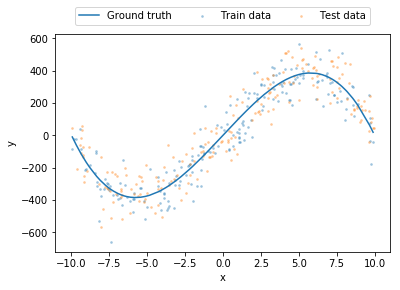

In [3]:
# Data generation

def gen_batch(n, w, beta):
    d = len(w)
    X = np.random.uniform(-10, 10, (n, 1))
    X = np.sort(X, axis=0)
    X = np.hstack([X ** i for i in range(d)])
    t = X.dot(w) + np.random.normal(size=n) / beta ** 0.5
    return X, t

n = 200
d = 30#21
w_true = np.zeros(d)
w_true[1] = 100
w_true[3] = -1
beta_true = 1e-4

X_train, t_train = gen_batch(n, w_true, beta_true)
X_test, t_test = gen_batch(n, w_true, beta_true)

# Visualization
plt.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
plt.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
plt.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')

plt.axes().set_xlabel('x')
plt.axes().set_ylabel('y')
plt.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()

In [4]:
# Relevance Vector Regression
w_rvr, sigma_rvr, alpha_rvr, beta_rvr = fit_rvr(X_train, t_train)

 90.0 %: 5


In [5]:
# Ridge Regression with Cross-Validation
from sklearn.linear_model import RidgeCV
ridge = RidgeCV(cv=20, alphas=10.**np.arange(-6, 3, 1),
                fit_intercept=False).fit(X_train, t_train)
w_ridge = ridge.coef_
clear_output()

In [6]:
# Lasso Regression with Cross-Validation
from sklearn.linear_model import LassoCV, Lasso
lasso = LassoCV(cv=20, alphas=10.**np.arange(-6, 3, 1),
                fit_intercept=False).fit(X_train, t_train)
w_lasso = lasso.coef_
clear_output()

Relevance Vector Regression
Features remaining: 3 / 30
Train error: 9052.796709305048
Test error:  9793.464126594487
--------------------------------------------------
Ridge Regression
Features remaining: NA (no sparsity)
Train error: 1122463.6078695157
Test error:  1853754.1252574667
--------------------------------------------------
Lasso Regression
Features remaining: 21 / 30
Train error: 13764.989896874951
Test error:  13517.774700905626


/usr/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


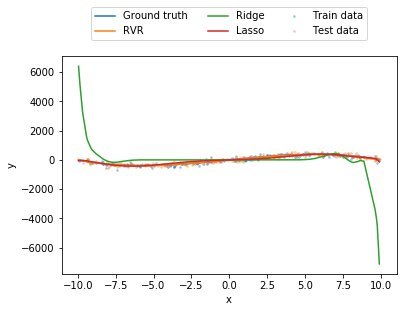

In [7]:
# Comparison
print('Relevance Vector Regression')
print('Features remaining:', np.sum(alpha_rvr < 1e8), '/', d)
print('Train error:', l2_error(X_train, t_train, w_rvr) / n)
print('Test error: ', l2_error(X_test, t_test, w_rvr) / n)
print('-' * 50)
print('Ridge Regression')
print('Features remaining: NA (no sparsity)')
print('Train error:', l2_error(X_train, t_train, w_ridge) / n)
print('Test error: ', l2_error(X_test, t_test, w_ridge) / n)
print('-' * 50)
print('Lasso Regression')
print('Features remaining:', np.sum(np.abs(w_lasso) > 1e-20), '/', d)
print('Train error:', l2_error(X_train, t_train, w_lasso) / n)
print('Test error: ', l2_error(X_test, t_test, w_lasso) / n)

plt.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
plt.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
plt.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')
plt.plot(X_train[:, 1], X_train.dot(w_rvr), label='RVR')
plt.plot(X_train[:, 1], X_train.dot(w_ridge), label='Ridge')
plt.plot(X_train[:, 1], X_train.dot(w_lasso), label='Lasso')

plt.axes().set_xlabel('x')
plt.axes().set_ylabel('y')
plt.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

## Регрессия с RBF-признаками

Здесь решается другая модельная задача: необходимо восстановить зашумленную функцию `sinc(x)`. Предлагается применить kernel trick с RBF-ядром (можно использовать функцию `sklearn.metrics.pairwise.rbf_kernel`), обучить три модели: SVM-регрессию (SVR), L1-регрессию (Lasso) и RVR, и сравнить ошибку на тестовой выборке и качество отобранных опорных / релевантных объектов.

/usr/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


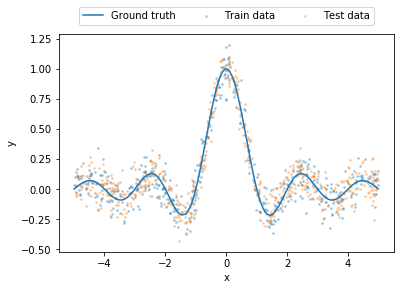

In [8]:
# Генерация данных
from sklearn.metrics.pairwise import rbf_kernel

def gen_batch(n, beta):
    points = np.random.uniform(-5, 5, n)
    points = np.sort(points)
    t = np.sinc(points) + np.random.normal(size=n) / beta ** 0.5
    return points, t

n = 500
d = 10
beta_true = 100

points_train, t_train = gen_batch(n, beta_true)
points_test, t_test = gen_batch(n, beta_true)

# RBF-transform
def extend(array):
    return np.reshape(array, [-1, 1])

X_train = rbf_kernel(extend(points_train), extend(points_train))
X_test = rbf_kernel(extend(points_test), extend(points_test))

# Constant feature
X_train = np.hstack((np.ones((n, 1)), X_train))
X_test = np.hstack((np.ones((n, 1)), X_test))

# Visualization
plt.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
plt.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)
plt.plot(points_train, np.sinc(points_train), label='Ground truth')

plt.axes().set_xlabel('x')
plt.axes().set_ylabel('y')
plt.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()

In [9]:
# Relevance Vector Regression
w_rvr, sigma_rvr, alpha_rvr, beta_rvr = fit_rvr(X_train, t_train, max_iter=1000000)

 99.9 %: 24


In [10]:
# Lasso Regression with Cross-Validation
from sklearn.linear_model import LassoCV
lasso = LassoCV(cv=10, alphas=10.**np.arange(-6, 3, 1),
                fit_intercept=False).fit(X_train, t_train)
w_lasso = lasso.coef_

/usr/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [11]:
# Support Vector Regression
from sklearn.svm import SVR
svr = SVR(gamma=1, tol=1e-6, C=1).fit(points_train.reshape(-1, 1), t_train)

/usr/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Relevance Vector Regression
Objects remaining: 14 / 500
Train error: 0.009484213810284142
Test error:  0.06025552915557006
--------------------------------------------------
Lasso Regression
Objects remaining: 148 / 500
Train error: 0.009456249975432644
Test error:  0.02785535601581545
--------------------------------------------------
Support Vector Regression
Objects remaining: 163 / 500
Train error: 0.00947339517677802
Test error:  0.00948180161155009


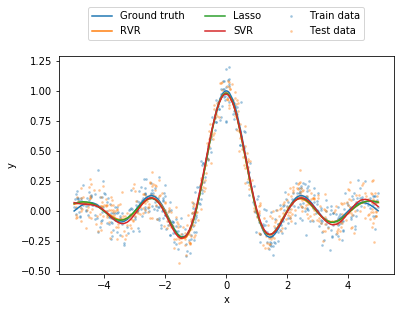

In [12]:
# Comparison
print('Relevance Vector Regression')
print('Objects remaining:', np.sum(alpha_rvr[1:] < 1e8), '/', n)
print('Train error:', l2_error(X_train, t_train, w_rvr) / n)
print('Test error: ', l2_error(X_test, t_test, w_rvr) / n)
print('-' * 50)
print('Lasso Regression')
print('Objects remaining:', np.sum(np.abs(w_lasso[1:]) > 1e-20), '/', n)
print('Train error:', l2_error(X_train, t_train, w_lasso) / n)
print('Test error: ', l2_error(X_test, t_test, w_lasso) / n)
print('-' * 50)
print('Support Vector Regression')
print('Objects remaining:', len(svr.support_), '/', n)
print('Train error:', np.sum((svr.predict(points_train.reshape(-1, 1)) - t_train) ** 2) / n)
print('Test error: ', np.sum((svr.predict(points_test.reshape(-1, 1)) - t_test) ** 2) / n)

plt.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
plt.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)
plt.plot(points_train, np.sinc(points_train), label='Ground truth')
plt.plot(points_train, X_train.dot(w_rvr), label='RVR')
plt.plot(points_train, X_train.dot(w_lasso), label='Lasso')
plt.plot(points_train, svr.predict(points_train.reshape(-1, 1)), label='SVR')

plt.axes().set_xlabel('x')
plt.axes().set_ylabel('y')
plt.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

### Визуализация релевантных объектов для RVR

/usr/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


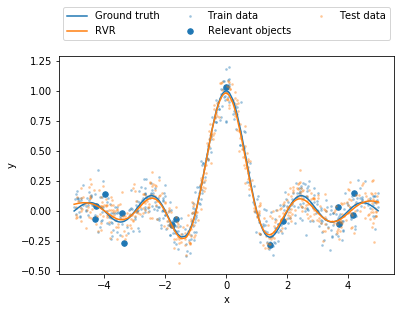

In [13]:
relevant = alpha_rvr[1:] < 1e8
plt.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
plt.scatter(points_train[relevant], t_train[relevant], c='tab:blue', s=30, label='Relevant objects')
plt.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)
plt.plot(points_train, np.sinc(points_train), label='Ground truth')
plt.plot(points_train, X_train.dot(w_rvr), label='RVR')

plt.axes().set_xlabel('x')
plt.axes().set_ylabel('y')
plt.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

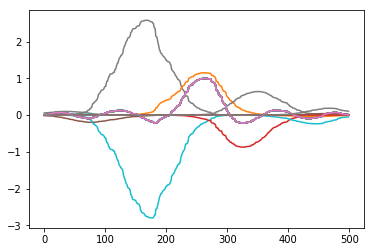

In [14]:
relevant = w_rvr != 0
indices = np.array([
    index
    for index, rel in enumerate(relevant)
    if rel
])
for rel in indices:
    plt.plot(np.sinc(points_train), label='Ground truth')
    plt.plot(X_train[:, rel] * w_rvr[rel])

## Выводы
В этом поле опишите свои наблюдения и сформулируйте свои выводы